In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.model_selection  import train_test_split
from torchvision import transforms
import torch
from torch.utils.data import Dataset
import torchvision
from sklearn.preprocessing import LabelEncoder
from torchinfo import summary
from tqdm.auto import tqdm
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torchvision import transforms
from transformers import ViTImageProcessor, ViTForImageClassification
from torch import nn
from typing import Tuple, Dict, List
from pathlib import Path
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
file_path = '/kaggle/input/digital-knee-xray/MedicalExpert-I'

labels = list(os.listdir(file_path))
print(labels)

['1Doubtful', '3Moderate', '4Severe', '2Mild', '0Normal']


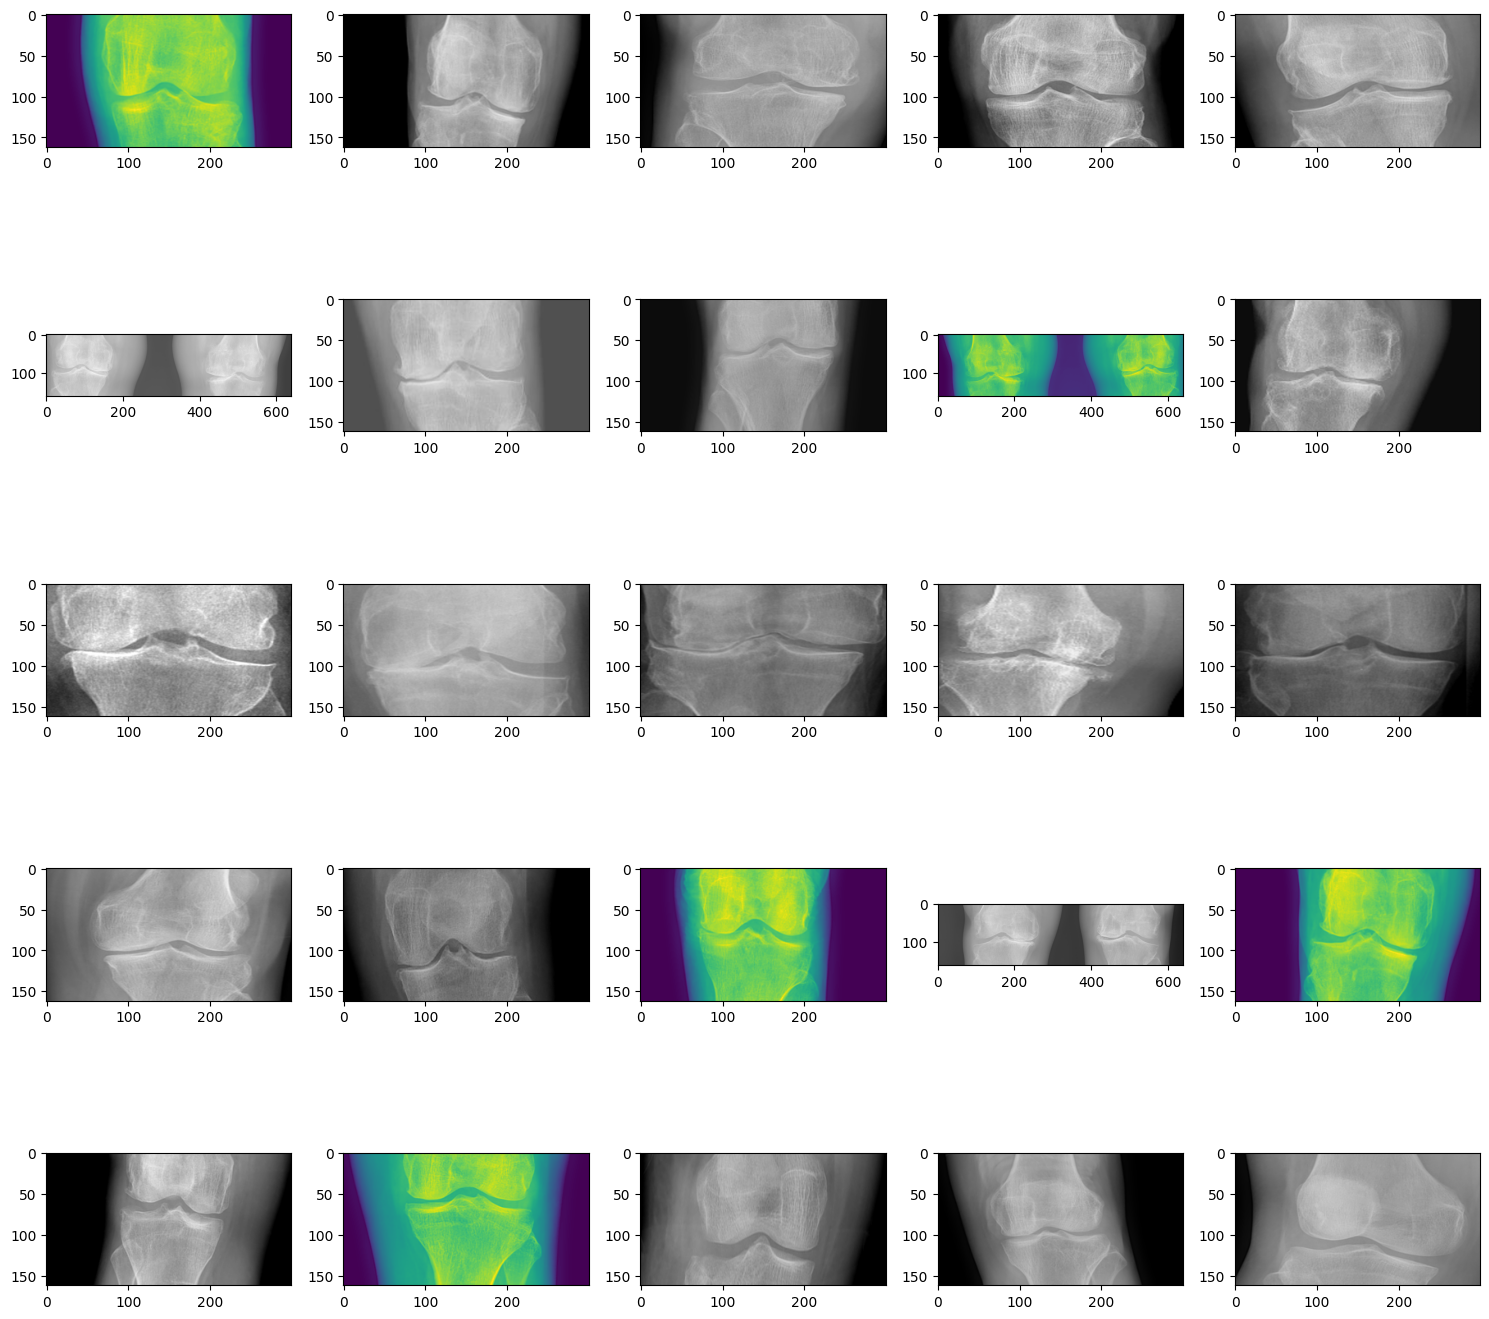

In [3]:
def show_sample_images(file_path, labels):
    random_indices = np.random.choice(range(1, 25), 10)
    fig, axes = plt.subplots(nrows=len(labels), ncols=5, figsize=(15,  3 * len(labels)))
    for row, label in enumerate(labels):
        cat_path = os.path.join(file_path, label)
        image_files = os.listdir(cat_path)
        for e, img in enumerate(image_files[:5] ):
            image = Image.open(os.path.join(cat_path, img))
            axes[row][e].imshow(image)
    plt.tight_layout()
    plt.show()

show_sample_images(file_path, labels)

In [4]:
image_path_list = []
label_list = []
full_path = '/kaggle/input/digital-knee-xray'
for files in os.listdir(full_path):
    for class_cat in os.listdir(full_path+'/'+files):
        file_path = full_path+'/'+files
        for image_object in os.listdir(file_path+'/'+class_cat):
            image_path_list.append(file_path+'/'+class_cat+'/'+image_object)
            label_list.append(f"{class_cat}")
df = pd.DataFrame()
df["image_path"] = image_path_list
df["label"] = label_list
df.head(10)

,image_path,label
0,/kaggle/input/digital-knee-xray/MedicalExpert-...,1Doubtful
1,/kaggle/input/digital-knee-xray/MedicalExpert-...,1Doubtful
2,/kaggle/input/digital-knee-xray/MedicalExpert-...,1Doubtful
3,/kaggle/input/digital-knee-xray/MedicalExpert-...,1Doubtful
4,/kaggle/input/digital-knee-xray/MedicalExpert-...,1Doubtful
5,/kaggle/input/digital-knee-xray/MedicalExpert-...,1Doubtful
6,/kaggle/input/digital-knee-xray/MedicalExpert-...,1Doubtful
7,/kaggle/input/digital-knee-xray/MedicalExpert-...,1Doubtful
8,/kaggle/input/digital-knee-xray/MedicalExpert-...,1Doubtful
9,/kaggle/input/digital-knee-xray/MedicalExpert-...,1Doubtful


In [5]:
test_ratio = 0.30 # 20% of data will go to test
### add y value(target) in stratify
train_df, eval_test_df = train_test_split(df, test_size=test_ratio, stratify=df['label'], random_state=42)
print(eval_test_df.shape)
test_df, eval_df = train_test_split(eval_test_df, test_size=0.1, stratify=eval_test_df['label'], random_state=42)
print(train_df.shape, test_df.shape, eval_df.shape)

(990, 2)
(2310, 2) (891, 2) (99, 2)


In [6]:
class ImageDataLoader(Dataset):
    def __init__(self, df, class_list, transform=None):
        self.df = df
        self.transform = transform
        self.class_list = class_list

        self.label_encoder = LabelEncoder()
        self.df['label'] = self.label_encoder.fit_transform(self.df['label'])  

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        # Load image path and label from dataframe
        img_path = self.df.iloc[index]['image_path']  
        label = self.df.iloc[index]['label']  
        
        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Apply transformation if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
IMAGE_SIZE = 224
train_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.Grayscale(num_output_channels=3),
                                            transforms.RandomRotation(10),
                                             transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.Grayscale(num_output_channels=3),
                                             transforms.ToTensor()])

In [8]:

test_data = ImageDataLoader(test_df, labels, test_transform)
train_data = ImageDataLoader(train_df, labels, train_transform)
# then use DataLoader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32,
                                          shuffle=True, num_workers=2)



testloader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          shuffle=False, num_workers=2)

In [9]:
len(train_data), len(test_data)

(2310, 891)

In [10]:
sample_image, sample_label = test_data[0]
print(sample_image.shape, sample_label)

torch.Size([3, 224, 224]) 3


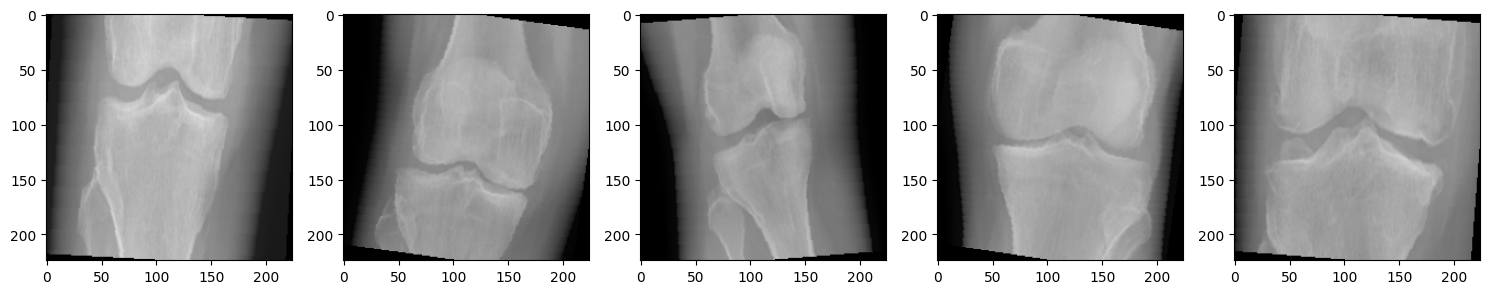

In [11]:
fig, ax = plt.subplots(1,5,figsize=(15,15))
for i in range(5):
    random_index = np.random.randint(0, len(train_data))
    img, label = train_data[random_index]
    img = img.permute(1, 2, 0)
    ax[i].imshow(img.numpy())
plt.tight_layout()  
plt.show()

In [12]:
#pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 
#pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

#for parameter in pretrained_vit.parameters():
#    parameter.requires_grad = False


#set_seeds()
#pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(labels))

In [13]:
model_name = "/kaggle/input/vit-base-patch16-224-in21k/transformers/default/1"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(labels))


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at /kaggle/input/vit-base-patch16-224-in21k/transformers/default/1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Load model directly
#from transformers import AutoImageProcessor, AutoModel
#processor = AutoImageProcessor.from_pretrained(model_name)
#model = AutoModel.from_pretrained(model_name)


In [15]:
# Set number of epochs
NUM_EPOCHS = 10
import torch.nn as nn


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [16]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # 1. Forward pass
        y_pred = model(X)
        logits = y_pred.logits  # Extract the logits from the model output
        
        # 2. Calculate the loss (logits and true labels)
        loss = loss_fn(logits, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class =  torch.argmax(logits, dim=1)

        train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
    
            # 1. Forward pass
            test_pred_logits = model(X)
            logits = test_pred_logits.logits  # Extract the logits from the model output
  
            # 2. Calculate and accumulate loss
            loss = loss_fn(logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = torch.argmax(logits, dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

    
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    best_loss = float('inf')
    epochs_no_improve = 0
    patience = 2
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

     
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            break

    return results

In [17]:
model_0_results = train(model=model, 
                        train_dataloader=trainloader,
                        test_dataloader=testloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4242 | train_acc: 0.3826 | test_loss: 1.2899 | test_acc: 0.4775
Epoch: 2 | train_loss: 1.1284 | train_acc: 0.5908 | test_loss: 1.0985 | test_acc: 0.5860
Epoch: 3 | train_loss: 0.9320 | train_acc: 0.7158 | test_loss: 1.0669 | test_acc: 0.5674
Epoch: 4 | train_loss: 0.7816 | train_acc: 0.7618 | test_loss: 0.8007 | test_acc: 0.7599
Epoch: 5 | train_loss: 0.6825 | train_acc: 0.7907 | test_loss: 0.7369 | test_acc: 0.7608
Epoch: 6 | train_loss: 0.6032 | train_acc: 0.8291 | test_loss: 0.6655 | test_acc: 0.7845
Epoch: 7 | train_loss: 0.5410 | train_acc: 0.8409 | test_loss: 0.6387 | test_acc: 0.7845
Epoch: 8 | train_loss: 0.4711 | train_acc: 0.8684 | test_loss: 0.6190 | test_acc: 0.7999
Epoch: 9 | train_loss: 0.4147 | train_acc: 0.8926 | test_loss: 0.5632 | test_acc: 0.8213
Epoch: 10 | train_loss: 0.3901 | train_acc: 0.8968 | test_loss: 0.5083 | test_acc: 0.8392


In [18]:
print(type(model))

<class 'transformers.models.vit.modeling_vit.ViTForImageClassification'>


In [19]:
from pathlib import Path


# Create model save path
MODEL_NAME = r"/kaggle/working\xray_classification.pth"

# Save the model state dict
print(f"Saving model to: {MODEL_NAME}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_NAME)

Saving model to: /kaggle/working\xray_classification.pth


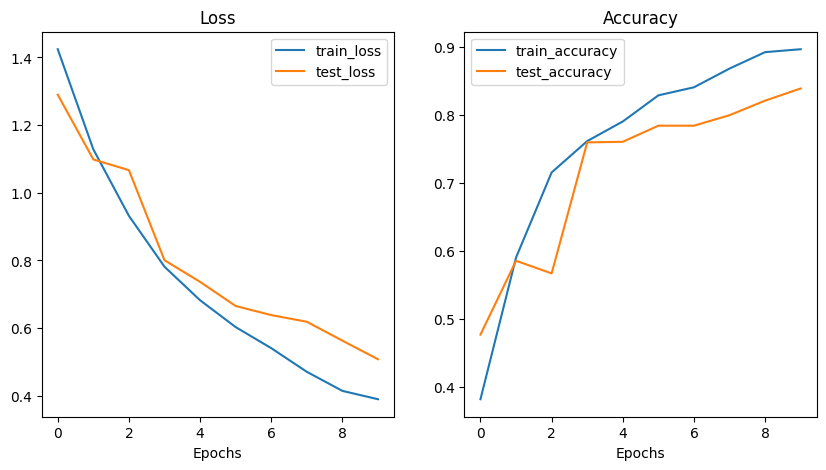

In [20]:
from typing import Tuple, Dict, List
def plot_loss_curves(results):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    

plot_loss_curves(model_0_results)

<ipython-input-82-3cc6b018d743>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH))


/kaggle/input/digital-knee-xray/MedicalExpert-II/3Moderate/ModerateG3 (84).png


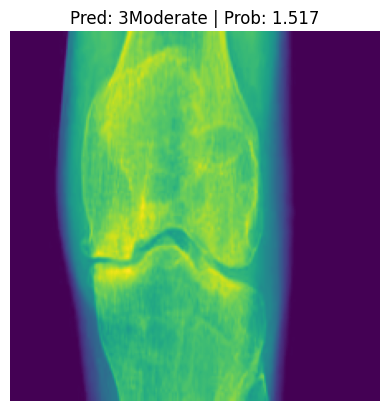

In [82]:

MODEL_SAVE_PATH = r"/kaggle/working\xray_classification.pth"

def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None, is_plot = False):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    if target_image.shape[0] == 1:
        target_image = target_image.repeat(3, 1, 1)
    
    #print(image_path)
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    #print(target_image.shape)
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    #print(target_image.shape)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
        
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image)
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = target_image_pred.logits

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    #print(target_image_pred_label, target_image.shape, target_image.squeeze().shape)
    # 8. Plot the image alongside the prediction and prediction probability
    if is_plot:
        plt.imshow(target_image.squeeze().mean(dim=0) ) # make sure it's the right size for matplotlib
        if class_names:
            title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        else: 
            title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        
        plt.title(title)
        plt.axis(False);

    return class_names[target_image_pred_label]
    
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), transforms.Resize((224, 224)),
])

# Load saved weights
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Set to evaluation mode
model.eval()



# Pred on our custom image
img_path = eval_df.iloc[5]['image_path']
pred_and_plot_image(model=model,
                    image_path=img_path,
                    class_names=['0Normal','1Doubtful', '2Mild','3Moderate','4Severe'],
                    transform=custom_image_transform, is_plot = True)
print(img_path)

0Normal


'0Normal'

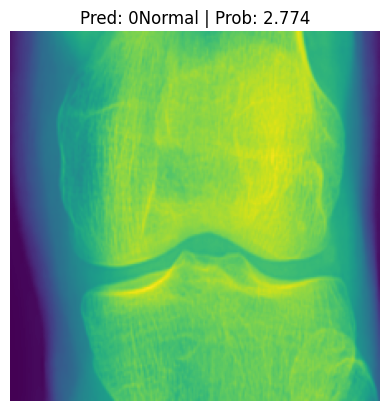

In [83]:
img_path = eval_df.iloc[98]['image_path']
print(img_path.split('/')[-2])
# Pred on our custom image
pred_and_plot_image(model=model,
                    image_path=img_path,
                    class_names=['0Normal','1Doubtful', '2Mild','3Moderate','4Severe'],
                    transform=custom_image_transform, is_plot = True)

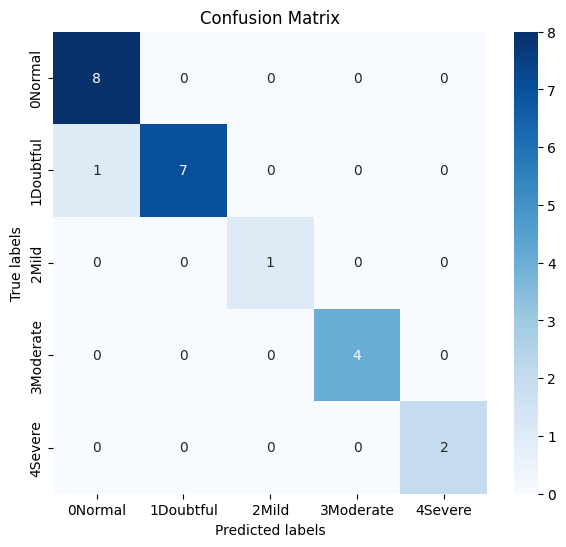

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Get the confusion matrix
cm = confusion_matrix(y_true_list, y_pred_list)
target_names = ['0Normal','1Doubtful', '2Mild','3Moderate','4Severe']

# Plot the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_true_list, y_pred_list, digits=4))

              precision    recall  f1-score   support

     0Normal     0.8889    1.0000    0.9412         8
   1Doubtful     1.0000    0.8750    0.9333         8
       2Mild     1.0000    1.0000    1.0000         1
   3Moderate     1.0000    1.0000    1.0000         4
     4Severe     1.0000    1.0000    1.0000         2

    accuracy                         0.9565        23
   macro avg     0.9778    0.9750    0.9749        23
weighted avg     0.9614    0.9565    0.9564        23

